In [1]:
import numpy as np
from matplotlib import pyplot as plt

import scipy.stats
from scipy import optimize
from scipy.stats import norm
from scipy.stats import uniform

from astroML import stats as astroMLstats
from astropy.visualization.hist import hist as fancyhist

from sklearn.neighbors import KernelDensity

import emcee
#import pymc3
import corner

#import dynesty

import sklearn

## Handwritten digits.

Sometimes you might want to apply multiple ML techniques. For example, just because you have labels in your training data doesn't mean that a regression algorithm will work very well.  So, you might want to start with a clustering or dimensional reduction algorithm first.

Here we're going to use the [MNIST database](https://en.wikipedia.org/wiki/MNIST_database). This contains a set of images with handwritten digts. It is one of the most widely used and best studied datasets in the whole of machine learning. It's part of the standard tests new tecniques need to face. 

Let's load the dataset first.

In [13]:
from sklearn import datasets
digits = datasets.load_digits()
print(digits.images.shape)
print(digits.keys())

(1797, 8, 8)
dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


In [15]:
print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

### Tasks. Part 0.

1) First thing, grab a piece of paper and visually classify those 25 digits. We'll see if you're better or worse than a computer! 

**Spoiler alert: Davide's efficiency was ~80%, much worse than ML!**


2) Here is how you plot the images and the corresponding labels  (The one thing I'm not telling you of course is the random seed I used to select those above). After you've seen this ones, go back to your piece of paper and update your choices if you want. Keep track of both set of preditions. This is like supervised learning.  


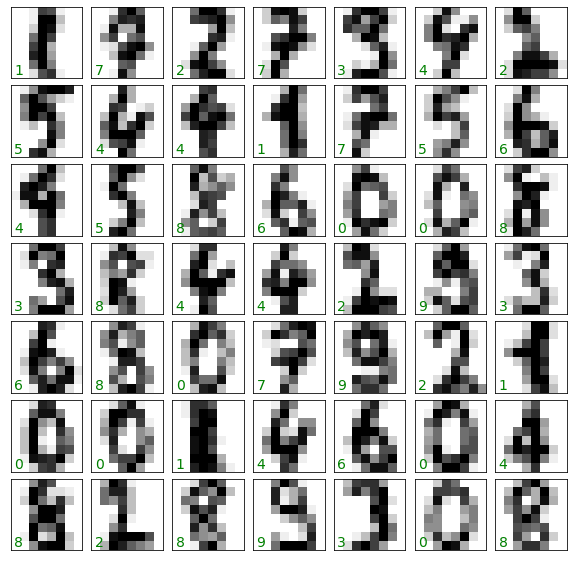

In [16]:
fig, axes = plt.subplots(7,7, figsize=(10, 10))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

np.random.seed(42)
mychoices = np.random.choice(digits.images.shape[0],100)

for i, ax in enumerate(axes.flat):
    ax.imshow((digits.images[mychoices[i]]), 
              cmap='binary')
    ax.text(0.05, 0.05, str(digits.target[mychoices[i]]),transform=ax.transAxes, color='green', fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])

Ok so the data is simply each pixel value within an $8\times 8$ grid.  For this analysis, we don't care about the $2$-D nature of the image, we can just treat it as an $8\times8=64$ dimensional array. So our data have $1797$ samples in $64$ dimensions.

Then each of the $1797$ ***images*** has a label.

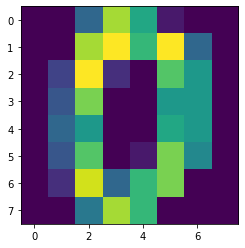

In [34]:
plt.imshow(digits.images[0])

In [37]:
print(digits.data.shape)

# The images themselves
print(digits.images[0])

# The data for use in our algorithms
print(digits.data[0])

# The labels
print(digits.target)
print(digits.target[0])

(1797, 64)
[[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]]
[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]
[0 1 2 ... 8 9 8]
0


### Tasks. Part 1. Unsupervised Learning: Dimensionality Reduction on Digits

We'd like to visualize our points within the 64-dimensional parameter space, but it's difficult to plot points in $N=64$ dimensions! So we need to reduce the dimensionality of the space


3) Use the unsupervised dimensionality reduction technique called **[`Isomap`](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html#sklearn.manifold.Isomap)**. Isomap is an embedding tecnique, which tries to understand if your $M$ dimensional datapoint live in a $N$ dimensional (with $N<M$) manyfold. Have a look at the Isomap documentation and reduce the MINST dataset.  Do some plots to visualize your results 

*Note*. Isomap is very recent. It was introduced by [Tenenbaum et al (2000)](https://www.science.org/doi/10.1126/science.290.5500.2319) ---a paper that has something like $1.5\times 10^4$ [citations](https://www.science.org/doi/full/10.1126/science.290.5500.2319).


In [53]:
from sklearn import manifold
# define the isomap 
isomap = sklearn.manifold.Isomap(n_neighbors=5,n_components=2) # default values for n_neigh and n_comp

# storing the embedding vectors
X = digits.data

X_transformed = isomap.fit_transform(X) # Fit the model from data in X and transform X
X_transformed.shape

(1797, 2)

Text(0, 0.5, 'axis 2')

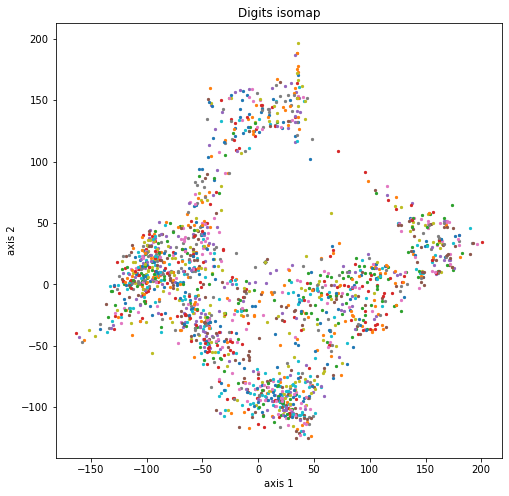

In [62]:
fig = plt.figure(figsize=(8,8))
for i in range((X_transformed.shape[0])):
    plt.scatter(X_transformed[i][0],X_transformed[i][1],s=5)
    
plt.title('Digits isomap')
plt.xlabel('axis 1')
plt.ylabel('axis 2')

### Tasks. Part 2. Supervised Learning: Classification on Digits

Now we want to classify the dataset. 

4) Split the dataset taking 80% of the images as tranining dataset and leaving the other 20% as a validation set. You need `sklearn.model_selection.train_test_split`.

In [66]:
from sklearn import model_selection

y = digits.target

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y,test_size=0.2,train_size=0.8)

5) Use a simple [`Logistic Regression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) which despite its name is a common classification algorithm. (I know, this is confusing!). Use the flag `solver='sag'`, the default solver had a bug, at least in my version.



Text(0.5, 0.98, 'predicted labels')

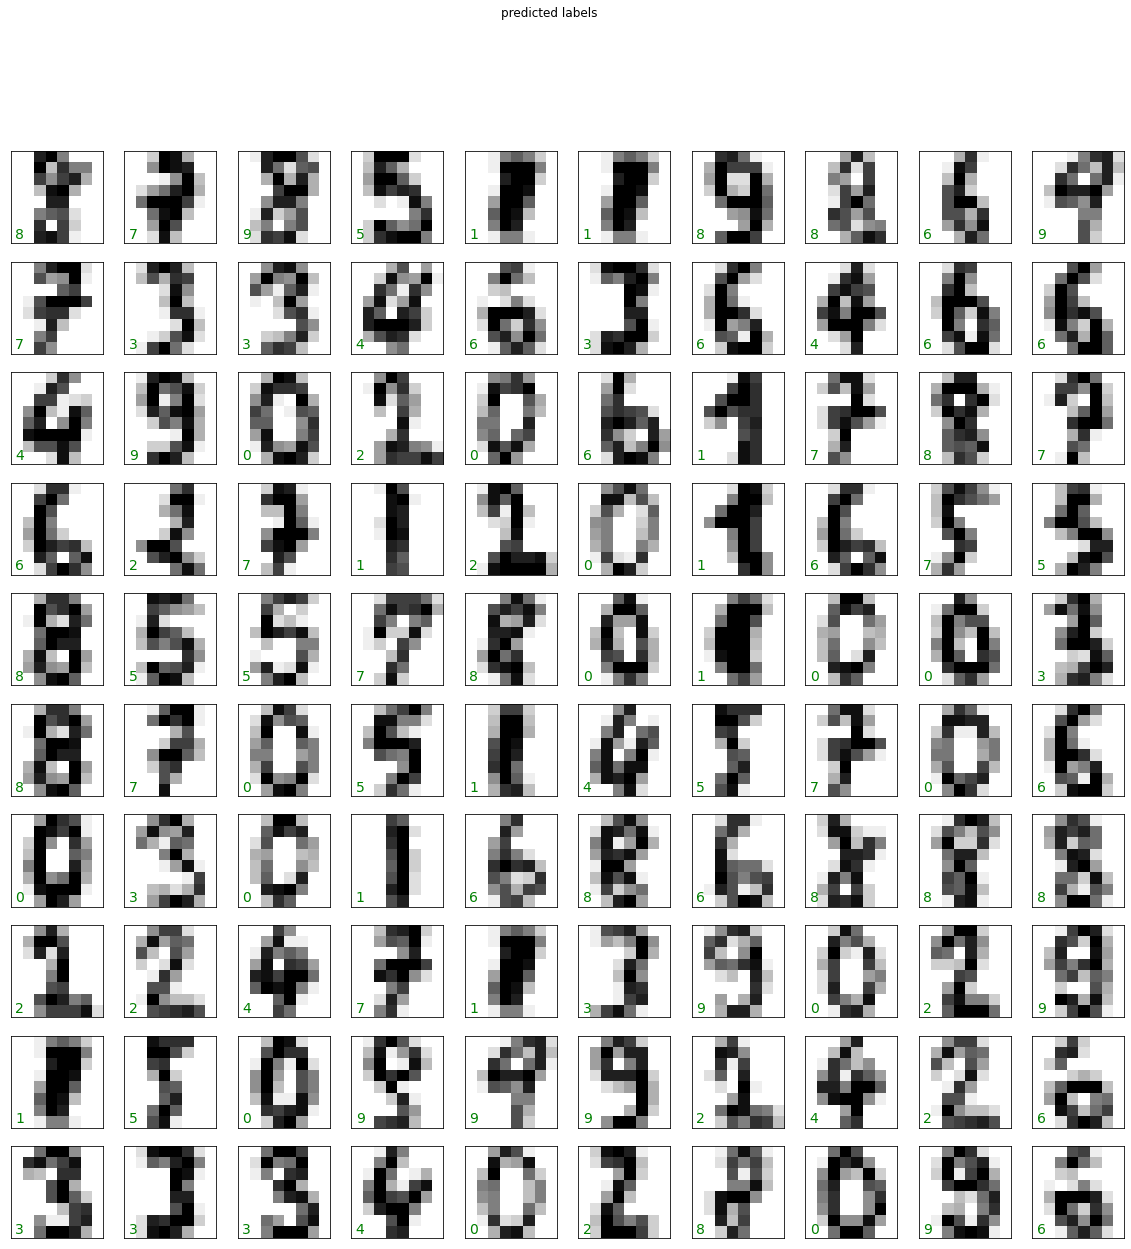

In [107]:
from sklearn import linear_model

clf = sklearn.linear_model.LogisticRegression(solver='sag',max_iter=1000).fit(X_train,y_train)
y_predict = clf.predict(X_test)

n_visual = 100
idx_visual = np.random.choice(np.arange(0,y_predict.shape[0]),n_visual)

fig, axes = plt.subplots(nrows=10,ncols=10,figsize=(20,20))

for i,idx,ax in zip(np.arange(0,n_visual),idx_visual,axes.flat):
    ax.imshow(X_test[idx].reshape(8,8),cmap='binary')
    ax.text(0.05, 0.05, str(y_predict[idx]),transform=ax.transAxes, color='green', fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.suptitle('predicted labels')

6) Compute the accuracy (`sklearn.metrics.accuracy_score`) of your emulator. In this context, accuracy is simply the fraction of the digits that were correctly identified. Compute the accuracy on both the training and the validation set. Comment on the results.

In [110]:
from sklearn import metrics

accuracy = sklearn.metrics.accuracy_score(y_true=y_test,y_pred=y_predict)
print('The accuracy of the emulator is:',accuracy)

The accuracy of the emulator is: 0.9777777777777777


7) The accuracy is a single number doesn't tell us ***where*** we've gone wrong. Plot the ***confusion matrix*** as we did above. What are the digits that are more challenging to identify, does it make sense?


There are many ways to improve this classifier, for example using a more sophisticated model, use cross validation, etc.  We'll get to those in the coming weeks.

In [111]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_predict))

[[39  0  0  0  0  0  0  0  0  0]
 [ 0 28  0  0  0  0  0  0  0  0]
 [ 0  0 36  0  0  0  0  0  0  0]
 [ 0  0  0 37  0  1  0  0  0  0]
 [ 0  0  0  0 29  0  0  0  0  0]
 [ 0  0  0  0  0 37  0  1  0  1]
 [ 0  0  0  0  0  0 48  0  0  0]
 [ 0  0  0  0  0  0  0 32  0  0]
 [ 1  1  0  0  0  0  0  0 32  1]
 [ 0  0  0  0  0  0  0  1  1 34]]
